In [1]:
import sys
import os
import traceback

import numpy as np
import tensorflow as tf
from skimage import exposure

import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
session_conf.gpu_options.allow_growth=True


In [3]:
import data
print(dir(data))
data_module = data.pascal

['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'pascal']


In [5]:

read_and_decode = data_module.read_and_decode
TRAIN_DIR = data_module.TF_DATA_DIR
W,H,C=(data_module.w,data_module.h,data_module.c)
num_samples = data_module.NUM_EXAMPLES_TRAIN
batch_size = 4
INPUT_TENSOR_NAME = 'inputs'

def eval_input_fn(training_dir=TRAIN_DIR, batch_size=batch_size, params=None):
    return _input_fn(training_dir, 'validation.tfrecords', batch_size=batch_size)

def _input_fn(training_dir, training_filename, batch_size=batch_size):
    test_file = os.path.join(training_dir, training_filename)
    filename_queue = tf.train.string_input_producer([test_file])

    image, label = read_and_decode(filename_queue)
    images, labels = tf.train.batch(
        [image, label], batch_size=batch_size,
        capacity=1000 + 10 * batch_size)
    return {INPUT_TENSOR_NAME: images}, labels

tf.reset_default_graph()

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
init = tf.global_variables_initializer()
sess.run(init)
images, labels = eval_input_fn()
coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(coord=coord,sess=sess)    
img, lbl = sess.run([images, labels])
batch = [img[INPUT_TENSOR_NAME],lbl]
print(batch[0].shape,batch[1].shape)
print(batch[1][0].shape)
# Stop the threads
coord.request_stop()
# Wait for threads to stop
coord.join(threads)


(4, 256, 256, 3) (4, 256, 256, 1)
(256, 256, 1)


In [6]:
batch_size

4

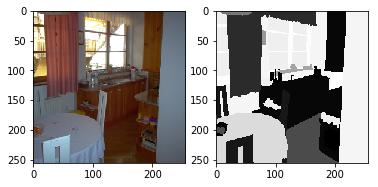

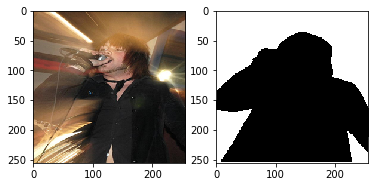

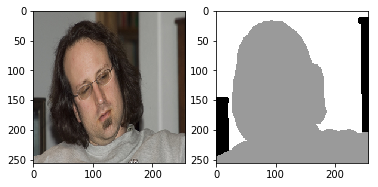

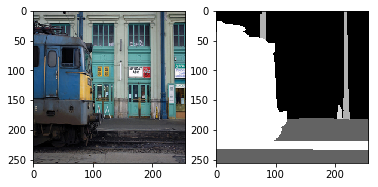

In [8]:
for n in range(batch_size):
    plt.figure(n)
    plt.subplot(121)
    plt.imshow(img['inputs'][n,:].squeeze(),cmap='gray')
    plt.subplot(122)
    plt.imshow(lbl[n,:].squeeze(),cmap='gray')

In [ ]:
training = True #<---seems to do the trick. for x_hat
params = {
    'learning_rate': 0.00001,
    'latent_dims':[10,10,10],
    'data_dims': [W,H,C],
    'is_training':training,
    'batch_size':batch_size,
    'warmup_until':10000,
    'g_scale_factor':0.2,
    'd_scale_factor':0.2,
    'recon_const':0.0,
    'latent_factor':0.02,
    'perceptual_factor':0.25,
}

In [ ]:
from fc_cvae_gan import Model, MODEL_DIR

In [ ]:
MODEL_DIR

In [ ]:
tf.reset_default_graph()
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
init = tf.global_variables_initializer()
sess.run(init)

In [ ]:
x = tf.placeholder(name='x', dtype=tf.float32, shape=[None, W,H,C])
l = tf.placeholder(name='loc', dtype=tf.float32, shape=[None, 1])
model = Model(**params)
model._build(x,l)
model.restore(tf.train.latest_checkpoint(MODEL_DIR))

In [ ]:
n = np.sqrt(batch_size).astype(np.int32)
h = H
w = W
I_hat = np.empty((h*n, 2*w*n))
I_z = np.empty((h*n, 2*w*n))
tf_images,tf_labels = eval_input_fn(batch_size=batch_size)
coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(coord=coord,sess=sess)

In [ ]:

img, lbl = sess.run([tf_images, tf_labels])
x = img[INPUT_TENSOR_NAME]
x_hat,z,loc_hat,x_p = model.sess.run([model.x_hat,model.z,model.loc_hat,model.x_p], feed_dict={model.x: x,})


In [ ]:
print(x.shape,np.max(x),np.min(x))
print(x_hat.shape,np.max(x_hat),np.min(x_hat))
print(x_p.shape,np.max(x_p),np.min(x_p))
print(z.shape,loc_hat.shape,x_p.shape)

In [ ]:

for i in range(n):
    for j in range(n):
        tmp = np.concatenate(
            (x_hat[i*n+j, :].reshape(h, w), 
             x[i*n+j, :].reshape(h, w)),
            axis=1
        )
        I_hat[i*h:(i+1)*h, j*2*w:(j+1)*2*w] = tmp
szx,szy = 60,30
plt.figure(0,figsize=(szx,szy))
plt.imshow(I_hat, cmap='gray')
plt.grid(False)
plt.savefig('result_compare_hat.png')

for i in range(n):
    for j in range(n):
        tmp = np.concatenate(
            (x_p[i*n+j, :].reshape(h, w), 
             x[i*n+j, :].reshape(h, w)),
            axis=1
        )
        I_z[i*h:(i+1)*h, j*2*w:(j+1)*2*w] = tmp

plt.figure(1,figsize=(szx,szy))
plt.imshow(I_z, cmap='gray')
plt.grid(False)
plt.savefig('result_compare_z.png')

print('done.')

In [ ]:
zc = np.copy(z)
zc+=np.random.normal(loc=0.0, scale=0.001, size=z.shape)
for q in range(11):
    plt.figure(q)
    plt.imshow(zc[0,:,:,q].squeeze(),cmap='gray')

In [ ]:
for q,scale in enumerate([0,0.1,0.3,0.6,5,100]):
    zc = np.copy(z)
    noise=np.random.normal(loc=0.0, scale=scale, size=z.shape)
    mask=np.zeros(z.shape)
    #mask[:,8:10,8:10,:]=1
    #zc+=mask*noise
    zc+=noise
    x_p = model.sess.run(model.x_p, feed_dict={model.zp:zc})
    for i in range(n):
        for j in range(n):
            tmp = np.concatenate(
                (x_hat[i*n+j, :].reshape(h, w), 
                 x[i*n+j, :].reshape(h, w)),
                axis=1
            )
            I_hat[i*h:(i+1)*h, j*2*w:(j+1)*2*w] = tmp
    szx,szy = 60,30
    plt.figure(q,figsize=(szx,szy))
    plt.subplot(121)
    plt.imshow(I_hat, cmap='gray')
    plt.grid(False)
    plt.savefig('result_compare_hat.png')

    for i in range(n):
        for j in range(n):
            tmp = np.concatenate(
                (x_p[i*n+j, :].reshape(h, w), 
                 x_hat[i*n+j, :].reshape(h, w)),
                axis=1
            )
            I_z[i*h:(i+1)*h, j*2*w:(j+1)*2*w] = tmp

    plt.subplot(122)
    plt.imshow(I_z, cmap='gray')
    plt.grid(False)
    plt.savefig('result_compare_z.png')

    print('done.')

In [ ]:


coord.request_stop()
# Wait for threads to stop
coord.join(threads)

